In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [87]:
data = pd.read_csv("input_data-1758089999111.csv")

In [88]:
original_data = data.copy()
original_data = original_data.dropna()

In [89]:
original_data.head(1)

,receipt_id,start_hour,start_day,start_week,start_weekday,warehouse_name,supplier_id,inbnd_type,sku_category_level_4_nm,sku_category_cnt,inbnd_duration_min
0,1003688760,13,29,22,4,РЦ СБЛ ВЛГ-2 WMS,a122042b-f9c7-11ea-8599-1c34dae33151,Хранение от поставщика,"Воды минеральные менее 0,8л",800.0,0.966624


## Преобразование данных

In [112]:
original_data['start_hour_sin'] = np.sin(2 * np.pi * original_data['start_hour'] / 24)
original_data['start_hour_cos'] = np.cos(2 * np.pi * original_data['start_hour'] / 24)

original_data['start_week_sin'] = np.sin(2 * np.pi * original_data['start_week'] / 7)
original_data['start_week_cos'] = np.cos(2 * np.pi * original_data['start_week'] / 7)

original_data['start_weekday_sin'] = np.sin(2 * np.pi * original_data['start_weekday'] / 52)
original_data['start_weekday_cos'] = np.cos(2 * np.pi * original_data['start_weekday'] / 52)


# x_train['start_hour'] = x_train['start_hour'].astype(str)
# x_train['start_day'] = x_train['start_day'].astype(str)
# x_train['start_week'] = x_train['start_week'].astype(str)
# x_train['start_weekday'] = x_train['start_weekday'].astype(str)

# x_test['start_hour'] = x_test['start_hour'].astype(str)
# x_test['start_day'] = x_test['start_day'].astype(str)
# x_test['start_week'] = x_test['start_week'].astype(str)
# x_test['start_weekday'] = x_test['start_weekday'].astype(str)

## Деление выборки

In [91]:
x = original_data.drop(['inbnd_duration_min'], axis=1)
y = original_data['inbnd_duration_min']

Логарифмирование 

In [92]:
y_log = np.log1p(y)

In [93]:
x_train, x_test, y_train_log, y_test_log = train_test_split(
    x , y_log, test_size=0.2, random_state=42, stratify=None
)

In [94]:
test_indices = x_test.index

In [95]:
len(x_test)

399

In [97]:
def handle_missing_data(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col].fillna('Unknown', inplace=True)
    
    return df

In [98]:
def encode_categorical_features(df):
    le = LabelEncoder()
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

In [99]:
x_test.dtypes

receipt_id                   int64
start_hour                   int64
start_day                    int64
start_week                   int64
start_weekday                int64
warehouse_name              object
supplier_id                 object
inbnd_type                  object
sku_category_level_4_nm     object
sku_category_cnt           float64
start_hour_sin             float64
start_hour_cos             float64
start_week_sin             float64
start_week_cos             float64
start_weekday_sin          float64
start_weekday_cos          float64
dtype: object

In [100]:
x_test = handle_missing_data(x_test)
x_test = encode_categorical_features(x_test)

x_train = handle_missing_data(x_train)
x_train = encode_categorical_features(x_train)

In [101]:
def drop_colums(df):
    df = df.drop(['receipt_id','supplier_id','start_hour','start_day', \
                  'start_week','start_weekday'], axis=1)
    return df

In [102]:
x_test = drop_colums(x_test)
x_train = drop_colums(x_train)

In [103]:
x_train

,warehouse_name,inbnd_type,sku_category_level_4_nm,sku_category_cnt,start_hour_sin,start_hour_cos,start_week_sin,start_week_cos,start_weekday_sin,start_weekday_cos
819,10,2,5,1134.0,9.659258e-01,2.588190e-01,-7.347881e-16,1.000000,0.354605,0.935016
1297,4,2,9,504.0,9.659258e-01,-2.588190e-01,7.818315e-01,0.623490,0.663123,0.748511
1464,5,2,24,36.0,8.660254e-01,5.000000e-01,9.749279e-01,-0.222521,0.239316,0.970942
1965,5,2,4,870.0,5.000000e-01,8.660254e-01,7.818315e-01,0.623490,0.464723,0.885456
1100,0,2,6,1824.0,8.660254e-01,-5.000000e-01,-7.818315e-01,0.623490,0.120537,0.992709
...,...,...,...,...,...,...,...,...,...,...
1140,9,2,18,168.0,2.588190e-01,-9.659258e-01,-1.224647e-15,1.000000,0.568065,0.822984
1306,6,2,9,1008.0,1.224647e-16,-1.000000e+00,-9.749279e-01,-0.222521,0.568065,0.822984
870,4,2,17,2160.0,1.000000e+00,6.123234e-17,7.818315e-01,0.623490,0.464723,0.885456
1471,8,2,9,504.0,7.071068e-01,7.071068e-01,9.749279e-01,-0.222521,0.000000,1.000000


In [104]:
y_train_log

819     2.027102
1297    0.695436
1464    0.112899
1965    0.942657
1100    2.403020
          ...   
1140    1.039218
1306    2.173953
870     3.151594
1471    0.957070
1136    2.019377
Name: inbnd_duration_min, Length: 1593, dtype: float64

## Обучение модели

In [105]:
params = {
    'boosting_type': 'gbdt',          # тип бустинга
    'objective': 'regression',        # задача регрессии
    'metric': 'mae',                  # метрика - средняя абсолютная ошибка
    'num_leaves': 32,                 # максимальное количество листьев в дереве
    'learning_rate': 0.02,            # скорость обучения
    'feature_fraction': 0.9,          # доля признаков для использования на каждой итерации
    'bagging_fraction': 0.8,          # доля данных для использования на каждой итерации
    'bagging_freq': 5,                # частота bagging
    'verbose': 0,                     # уровень детализации вывода
    'random_state': 42,               # для воспроизводимости
    'n_estimators': 2000,             # количество деревьев
    'max_depth': -1,                  # глубина деревьев (-1 = без ограничений)
    'min_data_in_leaf': 25,           # минимальное количество данных в листе
}

In [106]:
train_data = lgb.Dataset(x_train, label=y_train_log)
test_data = lgb.Dataset(x_test, label=y_test_log, reference=train_data)

In [107]:
# Обучение модели с ранней остановкой
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.462114
[200]	valid_0's l1: 0.440756
[300]	valid_0's l1: 0.435019
[400]	valid_0's l1: 0.430941
Early stopping, best iteration is:
[406]	valid_0's l1: 0.430629


In [108]:
y_pred_log = model.predict(x_test)

In [109]:
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

In [110]:
# Метрики качества
print(f"MAE (Средняя абсолютная ошибка): {mean_absolute_error(y_test, y_pred):.2f} минут")
print(f"MSE (Средняя квадратичная ошибка): {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE (Корень из MSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} минут")
print(f"R² (Коэффициент детерминации): {r2_score(y_test, y_pred):.4f}")

MAE (Средняя абсолютная ошибка): 4.10 минут
MSE (Средняя квадратичная ошибка): 168.44
RMSE (Корень из MSE): 12.98 минут
R² (Коэффициент детерминации): 0.1399


## Важность признаков

In [111]:
# 8. ВАЖНОСТЬ ПРИЗНАКОВ
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

print("\nТОП-15 ВАЖНЕЙШИХ ПРИЗНАКОВ:")
print(feature_importance.head(15))


ТОП-15 ВАЖНЕЙШИХ ПРИЗНАКОВ:
                   feature  importance
3         sku_category_cnt        3068
2  sku_category_level_4_nm        1791
0           warehouse_name        1556
6           start_week_sin        1508
8        start_weekday_sin        1183
7           start_week_cos        1145
5           start_hour_cos        1049
4           start_hour_sin         986
1               inbnd_type         172
9        start_weekday_cos         128


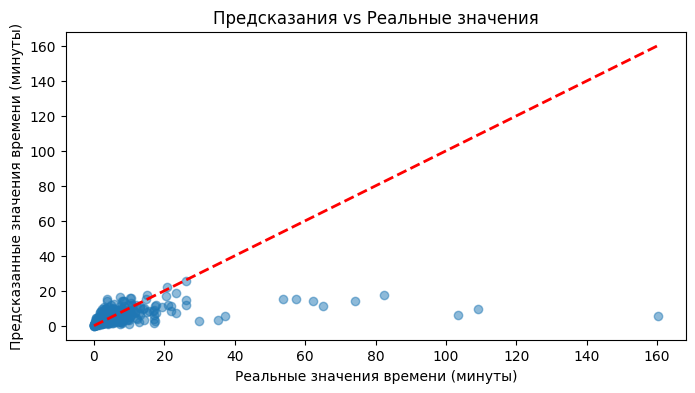

In [85]:
# 9. ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ vs РЕАЛЬНЫЕ ЗНАЧЕНИЯ
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальные значения времени (минуты)')
plt.ylabel('Предсказанные значения времени (минуты)')
plt.title('Предсказания vs Реальные значения')
plt.show()

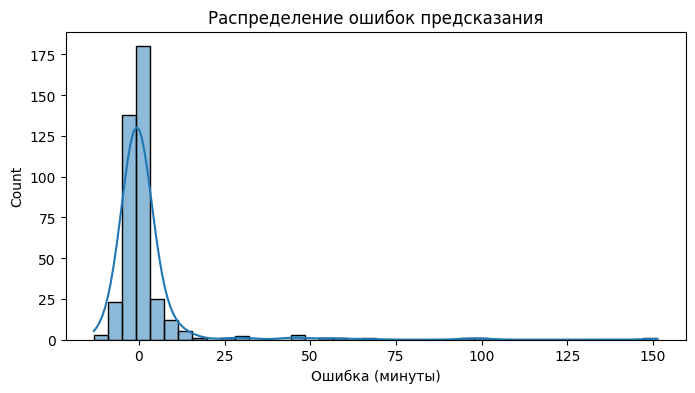

In [58]:
# 10. АНАЛИЗ ОШИБОК
errors = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True)
plt.title('Распределение ошибок предсказания')
plt.xlabel('Ошибка (минуты)')
plt.show()

In [59]:
# Создаем DataFrame с результатами
#results_df = x_test.copy()
results_df = original_data.loc[test_indices].copy()

# Добавляем предсказания и фактические значения
results_df['predicted_time'] = y_pred
results_df['actual_time'] = y_test

# Вычисляем ошибку
results_df['error'] = results_df['predicted_time'] - results_df['actual_time']

# Сохраняем в CSV
results_df.to_csv('predictions_results_level3.csv', index=False, encoding='utf-8-sig')

print("Файл сохранен: predictions_results_level3.csv")
print(f"Количество строк: {len(results_df)}")

Файл сохранен: predictions_results_level3.csv
Количество строк: 399
